# Synthetic Data Generation

> If you haven't already, please run the `1. Embedding Search.ipynb` notebook to setup your search system before running this notebook. That way you'll have a database with products and embeddings to work with and understand what our query understanding is performing.

One of the most powerful aspects of modern search development is the ability to use synthetic data for evaluation and improvement, even before gathering real user interactions. This approach becomes particularly powerful when combined with structured understanding of query types and intent.

## Understanding Query Patterns for Synthetic Data Generation

Based on our analysis of e-commerce search patterns, we can identify several common query structures:

- Complementary item queries: "accessories that go with leather jackets"
- Substitute product queries: "alternatives to Nike running shoes"
- Occasion-based queries: "outfits for summer wedding"
- Style-based queries: "minimalist scandinavian furniture"
- Seasonal context: "lightweight breathable workout gear for hot weather"

By understanding these patterns, we can create more targeted and effective synthetic data generation prompts. Let's see an example below of how we might use a few shot prompt to generate synthetic data to mimic a query looking for a complementary item.

In [6]:
import openai
from pydantic import BaseModel
import instructor

client = openai.OpenAI()
client = instructor.from_openai(client)


class SyntheticQuery(BaseModel):
    query: str


client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": "Generate a hypothetical query for a user looking for complementary items to existing ones they own (Eg. 'accessories that go with leather jackets'). The query should be in the form of a question, and should be a single sentence. Make sure to use a different item than the examples provided above",
        }
    ],
    response_model=SyntheticQuery,
)


SyntheticQuery(query='What types of footwear pair well with denim jeans?')

Let's look at an item from our dataset and see what variations we might be able to generate. We'll be using the `ivanleomk/timescale-ecommerce` dataset that we used previously in our embedding search notebook.

In [10]:
from datasets import load_dataset
from rich import print

dataset = load_dataset("ivanleomk/timescale-ecommerce")

item = dataset["train"][0]

print(item)


{
    'id': 1,
    'title': 'Lace Detail Sleeveless Top',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024 at 0x126913C50>,
    'description': "Elevate your casual wardrobe with this elegant sleeveless top featuring intricate lace 
detailing at the neckline. Perfect for both day and night, it's crafted from a soft, breathable fabric for all-day 
comfort.",
    'brand': 'H&M',
    'category': 'Tops',
    'subcategory': 'Tank Tops',
    'price': 181.04
}

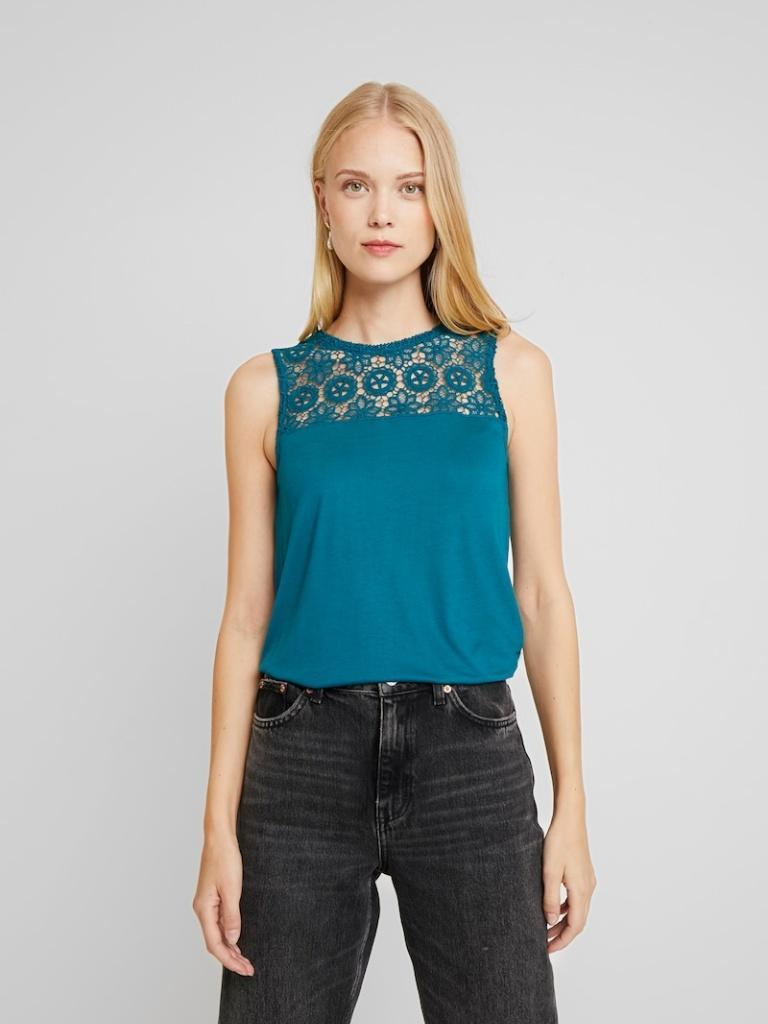

In [11]:
item['image']

What kind of queries might we be able to generate for this sleeveless top with lace details given the different categories of queries that we had above? We can brainstorm a few as seen below:

- Complementary item queries: "Sleeveless tops to pair with dark denim"
- Substitute product queries: "Casual tops with lace neckline detail"
- Occasion-based queries: "blue tops for a casual night out"
- Style-based queries: "minimalist elegant casual tank tops"
- Seasonal context: "Summer tops with lace details"

Even for the simple query of "sleeveless tops to pair with dark denim", we can think of a few more variations for the query in terms of sentence length, tone and other forms such as 

- Hey I'm hoping to find a good sleeveless top to pair with this great pair of dark denim jeans i have. Any recomendations that you might have in mind? -> Long, Verbose
- sleevess top w denim dark -> Short, Concise
- any new top w lace deets that go well with dark jens -> mis-spellings, casual, short

By varying the type of query and the phrasing of the query ( using tone, length and other forms such as mis-spellings), we can generate a large number of synthetic queries for a given item. This allows us to benchmark the retrieval performance of our search system using classic retrieval metrics such as precision, recall and NDCG.

## Generating Our First Synthetic Query

Let's now generate a synthetic query using the item above. We'll be including a few example queries in the prompt to help the model understand the task well.

In [14]:
import random


def generate_synthetic_query(item):
    query_types = [
        "Complementary item queries (Eg. Sleeveless tops to pair with dark denim)",
        "Substitute product queries (Eg. Casual tops with lace neckline detail)",
        "Occasion-based queries (Eg. blue tops for a casual night out)",
        "Style-based queries (Eg. minimalist elegant casual tank tops)",
        "Seasonal context (Eg. Summer tops with lace details)",
    ]

    query_styles = [
        "Short, concise (Eg. top no sleeve goes w dark denim?)",
        "Long, verbose (Eg. Hey I'm hoping to find a good sleeveless top to pair with this great pair of dark denim jeans i have. Any recomendations that you might have in mind?)",
    ]

    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": """
                Generate a natural shopping query where this item would be the perfect recommendation.
                
                The query should be in the form of a {{ query_type }} and written in {{ query_style }}. 

                Here is some information on the item
                {{ item }}

                Try to mention things which might be synonyms for the item and avoid mentioning it directly. Instead we should use specific attributes that the item has in order to make it a good fit. Make sure to use the exact attribute name so that it's unambigious.

                The query should be a single sentence and in the form of a question. 
                
                """,
            }
        ],
        context={
            "query_type": random.choice(query_types),
            "query_style": random.choice(query_styles),
            "item": item,
        },
        response_model=SyntheticQuery,
    )

    return {
        "id": item["id"],
        "query": resp.query,
    }

In [15]:
from itertools import islice
from rich import print

for item in islice(dataset["train"], 4):
    print(generate_synthetic_query(item))


{'id': 1, 'query': 'elegant sleeveless tops with lace detailing for casual day or night outings?'}

{
    'id': 2,
    'query': 'What casual tops with a relaxed fit and round neckline would pair well with my favorite denim?'
}

{
    'id': 3,
    'query': "Hi there, I'm on the lookout for a flowing, elegant piece that would pair beautifully with a casual 
top for both relaxed outings and more formal events; do you have any recommendations for a sophisticated, striped 
garment that offers both comfort and style?"
}

{
    'id': 4,
    'query': "I'm looking for a stylish short-sleeve t-shirt that features a sleek design and embodies sporty 
elegance, ideal for elevating my casual look this weekend; do you have any recommendations?"
}

We cannot use the same prompt and expect a diverse set of questions. Therefore we need to introduce slight variations in the prompt to generate questions that are different in wording, intent and content. This is crucial in identifying blindspots in our retrieval system.

In the example above, we're using the same prompt but introducing randomly chosen constraints at each point. This forces the model to write and generate different questions each time, allowing us to collect a more diverse set of questions. The key here is to really introduce different sources of variation when doing these generations.

## Evaluating Search Quality with IR Metrics

Since each query has a golden label - which corresponds to the item that was used to generate it, we can use it to evaluate the performance of our search system. Let's see how we can do so using our first query as an example.

We'll do so in 3 steps

1. First we'll walk through how to calculate the recall and Mean Reciprocal Rank (MRR) of a query and why we might want to calculate this at different levels of `k`
2. Then we'll use our query and calculate it's recall and MRR at different levels of `k`
3. Finally we'll see how we can use these metrics to evaluate the performance of our search system

Recall in this specific case measures whether our item is retrieved in the top `k` results while MRR measures the rank of our item in the top `k` results. These are two important metrics because they help us understand how well our search system is performing For a good search system, we want to see high recall and MRR values. A high recall means that our relevant item is retrieved while a high MRR means that our relevant item is retrieved in the top positions.

We want to calculate the metrics at different levels of `k` so we can see how the performance changes as we vary the number of results we retrieve for a given user query. 

In [18]:
def calculate_recall(predicted, labels):
    return sum(1 for label in labels if label in predicted) / len(labels)

def calculate_mrr(predicted, labels):
    for i, item in enumerate(predicted):
        if item in labels:
            return 1 / (i + 1)
    return 0


# What our model retrieved
predicted = ["a", "b", "c", "d", "e"]

# What we want to rank for the highest
labels = ["d"]

calculate_recall(predicted, labels), calculate_mrr(predicted, labels)

(1.0, 0.25)

Now that we've understood how to calculate the metrics and why we should care, let's see how our search system that we've built performs using the metrics we've just calculated.



In [32]:
import psycopg
from psycopg.rows import dict_row
from pgvector.psycopg import register_vector
import os
import instructor
import numpy as np
from jinja2 import Template
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Optional, Literal
from asyncio import Semaphore
import pandas as pd


load_dotenv()


def get_conn():
    conn = psycopg.connect(os.getenv("DB_URL"), row_factory=dict_row)
    register_vector(conn)
    return conn


class QueryFilters(BaseModel):
    avaliability: Literal["in-stock", "out-of-stock", "all"] = Field(
        description="Stock avaliability of item"
    )
    min_price: Optional[float] = None
    max_price: Optional[float] = None
    category: list[Literal["Outerwear", "Tops", "Activewear", "Dresses", "Bottoms"]]
    subcategory: list[
        Literal[
            "Jeans",
            "Athletic Shirts",
            "Vests",
            "Sweatshirts",
            "Pants",
            "Sweaters",
            "Shorts",
            "Tank Tops",
            "Skirts",
            "Leggings",
            "Cardigans",
            "Casual Dresses",
            "Blouses",
            "T-Shirts",
        ]
    ] = []


categories = ["Outerwear", "Tops", "Activewear", "Dresses", "Bottoms"]
subcategories = [
    "Jeans",
    "Athletic Shirts",
    "Vests",
    "Sweatshirts",
    "Pants",
    "Sweaters",
    "Shorts",
    "Tank Tops",
    "Skirts",
    "Leggings",
    "Cardigans",
    "Casual Dresses",
    "Blouses",
    "T-Shirts",
]


async def extract_query_filters(client: openai.AsyncOpenAI, query: str, sem: Semaphore):
    async with sem:
        return await client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": """
                    You are a helpful assistant that extracts user requirements from a query. 

                    You have the following categories and subcategories that you can use to extract the user's requirements. Err on the side of including more filters rather than less.

                    <categories>
                    {{categories}}
                    </categories>

                    <subcategories>
                    {{subcategories}}
                    </subcategories>

                    <availabilities>
                    in-stock, out-of-stock, all
                    </availabilities>
                    
                    Also extract out min price or max price if the user is looking for a specific price range. Let's work with a range that has at least $40 difference between the min and max price if the user does not specify a specific price (Eg. around 100 is going to translate to $60-$140 but under 100 is going to translate to $0-$100).
                    """,
                },
                {
                    "role": "user",
                    "content": "The user's query is: {{ query }}",
                },
            ],
            context={
                "query": query,
                "categories": categories,
                "subcategories": subcategories,
            },
            response_model=QueryFilters,
        )

async def search_with_filters(
    conn: psycopg.Connection,
    limit: int,
    query: str,
    sem: Semaphore,
    client: openai.AsyncOpenAI,
):
    filters = await extract_query_filters(client, query, sem)
    print(filters)
    embedding = (
        (await client.embeddings.create(input=query, model="text-embedding-3-small"))
        .data[0]
        .embedding
    )

    conditions = []

    if filters.min_price:
        conditions.append("price >= %(min_price)s")

    if filters.max_price:
        conditions.append("price <= %(max_price)s")

    if filters.category:
        conditions.append("category = ANY(%(category)s)")

    if filters.subcategory:
        conditions.append("subcategory = ANY(%(subcategory)s)")

    if filters.avaliability == "in-stock":
        conditions.append("quantity > 0")

    template = Template("""
SELECT * FROM products
{% if conditions %}
WHERE {{ conditions | join(' AND ') }}
{% endif %}
ORDER BY embedding <=> %(embedding)s
LIMIT %(limit)s
    """)

    query = template.render(filters=filters, conditions=conditions)

    # Flatten the parameters
    params = {
        "embedding": np.array(embedding),
        "limit": limit,
        "max_price": filters.max_price,
        "min_price": filters.min_price,
        "category": filters.category,
        "subcategory": filters.subcategory,
    }

    with conn.cursor() as cursor:
        results = cursor.execute(query, params).fetchall()

        return pd.DataFrame(results if results else [])

In [36]:
query = "elegant sleeveless tops with lace detailing for casual day or night outings?"

conn = get_conn()
sem = Semaphore(10)
results = await search_with_filters(conn, 5, query, sem, client)
results

QueryFilters(
    avaliability='all',
    min_price=None,
    max_price=None,
    category=['Tops'],
    subcategory=['Tank Tops', 'Blouses']
)

,id,title,description,brand,category,subcategory,quantity,price,embedding
0,1,Lace Detail Sleeveless Top,Elevate your casual wardrobe with this elegant...,H&M,Tops,Tank Tops,66,181.04,"[0.09288186, 0.04094521, -0.0020110768, -0.069..."
1,154,Lace Sleeve Top,This elegant top features delicate lace sleeve...,Zara,Tops,Blouses,73,101.15,"[0.08290469, 0.03701994, -0.031047639, -0.0685..."
2,173,Lace Trim V-Neck Top,Elevate your everyday look with this elegant s...,Express,Tops,Blouses,0,301.33,"[0.05979432, 0.010961599, -0.014657104, -0.050..."
3,186,Black Lace Long Sleeve Top,Elevate your look with this elegant black lace...,Zara,Tops,Blouses,0,270.23,"[0.05144285, -0.01660336, 0.0035756598, -0.050..."
4,19,Lace Detail Sleeveless Top,Elevate your ensemble with this elegant sleeve...,Zara,Tops,Tank Tops,42,259.52,"[0.05983859, 0.0059647886, -0.03280104, -0.037..."


In [39]:
calculate_recall(results["id"], [1]), calculate_mrr(results["id"], [1])

(1.0, 1.0)

Using synthetic data, we can generate large-scale test sets that cover various query patterns and evaluate against these metrics. This allows us to:

- Identify weaknesses in our search system before deploying to users
- Compare different search strategies systematically
- Measure improvements from query understanding and filtering enhancements
- Validate the effectiveness of hybrid approaches combining embedding and traditional search

The key to effective synthetic evaluation is ensuring your generated queries maintain realistic complexity and edge cases. Consider generating:

- Queries with implicit category filters
- Multi-intent queries combining multiple attributes
- Negative queries where certain results should be excluded
- Temporal and availability-sensitive queries

This comprehensive approach to synthetic evaluation provides a robust foundation for search development, allowing teams to iterate quickly and confidently before gathering real user data.

Now that we've covered the importance of synthetic data generation and evaluation, let's see how we can use this to improve our search system in the next notebook where we'll look at how we can use language models to generate metadata for our search system to enhance product discoverability and search quality.